<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Hand Written Digits Project</b>
</h1>

- The dataset is used for recognizing handwritten digits.

- It contains scanned images of handwritten digits.

- The dataset has a total of 10 classes, with each class representing a digit from 0 to 9.

- Data was collected from 44 subjects, with 250 samples from each.

- In addition to the image data, the dataset also includes information on which digit each image represents.

- This dataset is frequently used to evaluate the performance of machine learning algorithms in the field of handwriting recognition.

- It is also a popular dataset for training deep learning models.

**Pen-Based Handwritten Digit Recognition**

We created a digit database by collecting 250 samples from a total of 44 writers. Samples from 30 writers are used for training, cross-validation, and writer-dependent testing, while samples from the other 14 writers are used for writer-independent testing. This database is also available in UNIPEN format.

We used a WACOM PL-100V pressure-sensitive tablet with an integrated LCD screen and a wireless pen. The input and display areas are in the same place. This tablet, connected to an Intel 486-based computer via a serial port, allows us to collect handwriting samples. The tablet records the $x$ and $y$ coordinates and pen pressure values at fixed time intervals of 100 milliseconds.

Each writer was asked to randomly write 250 digits inside 500x500 pixel boxes on the tablet. The participants were only observed during the initial input screens. Each screen displayed five boxes with the digits to be written. They were instructed to write inside these boxes. If they made a mistake or were unsatisfied with their input, they could clear a box using an on-screen button. The first ten digits were disregarded, as most writers were unfamiliar with such input devices, though they were unaware of this.

In our study, we only used the ($x, y$) coordinate data, ignoring the pen pressure values. We applied normalization to make our representation invariant to translation and scale distortions. The raw data from the tablet are integer values ranging from 0 to 500 (the resolution of the tablet input box). The new coordinates are scaled so that the coordinate with the maximum range varies between 0 and 100.

**Feature Information**

To train and test our models, we need to represent the digits as fixed-length feature vectors. A common technique that yields good results is resampling the ( x_t, y_t) points. Temporal resampling (points placed at regular intervals in time) or spatial resampling (points placed at regular intervals along the arc length) can be used. The raw point data are already spaced regularly in time, but the distance between them varies. Previous research has shown that spatial resampling performs much better, as it provides better alignment between points. Our resampling algorithm uses simple linear interpolation between point pairs. The resampled digits are represented as a sequence of T points ( x_t, y_t )_{t=1}^T, spaced at regular intervals along the arc length, instead of regularly spaced in time.

Thus, the input vector size is 2*T, twice the number of resampled points. In our experiments, we considered spatial resampling to T=8,12,16 points and found that T=8 provided the best balance between accuracy and complexity.

**Data reference link:**

1. [TÜBİTAK Article](https://journals.tubitak.gov.tr/cgi/viewcontent.cgi?article=3717&context=elektrik)
2. [UCI Machine Learning Repository: Pen-Based Recognition of Handwritten Digits Dataset](https://archive.ics.uci.edu/dataset/81/pen+based+recognition+of+handwritten+digits)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.rcParams["figure.figsize"] = (9, 5)

import warnings

warnings.filterwarnings('ignore')

<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Exploratory Data Analysis</b>
</h1>


In [2]:
df0 = pd.read_csv("pendigits_txt.csv")
df = df0.copy()

In [3]:
df.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10992 entries, 0 to 10991
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   input1   10992 non-null  int64
 1   input2   10992 non-null  int64
 2   input3   10992 non-null  int64
 3   input4   10992 non-null  int64
 4   input5   10992 non-null  int64
 5   input6   10992 non-null  int64
 6   input7   10992 non-null  int64
 7   input8   10992 non-null  int64
 8   input9   10992 non-null  int64
 9   input10  10992 non-null  int64
 10  input11  10992 non-null  int64
 11  input12  10992 non-null  int64
 12  input13  10992 non-null  int64
 13  input14  10992 non-null  int64
 14  input15  10992 non-null  int64
 15  input16  10992 non-null  int64
 16  class    10992 non-null  int64
dtypes: int64(17)
memory usage: 1.4 MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
input1,10992.0,38.814320,34.257783,0.0,6.0,32.0,65.0,100.0
input2,10992.0,85.120269,16.218571,0.0,76.0,89.0,100.0,100.0
input3,10992.0,40.605622,26.342984,0.0,20.0,40.0,58.0,100.0
input4,10992.0,83.774199,19.163646,0.0,72.0,91.0,100.0,100.0
input5,10992.0,49.770378,34.100515,0.0,18.0,53.0,78.0,100.0
input6,10992.0,65.573144,26.996688,0.0,49.0,71.0,86.0,100.0
input7,10992.0,51.220251,30.576881,0.0,28.0,53.5,74.0,100.0
input8,10992.0,44.498999,29.906104,0.0,23.0,43.0,64.0,100.0
input9,10992.0,56.868541,34.135530,0.0,29.0,60.0,89.0,100.0
input10,10992.0,33.695961,27.251548,0.0,7.0,33.0,54.0,100.0


In [6]:
df.isnull().sum()

input1     0
input2     0
input3     0
input4     0
input5     0
input6     0
input7     0
input8     0
input9     0
input10    0
input11    0
input12    0
input13    0
input14    0
input15    0
input16    0
class      0
dtype: int64

In [7]:
df.shape

(10992, 17)

In [8]:
object_columns = df.select_dtypes(include=["object"]).columns
print(object_columns)

Index([], dtype='object')


In [9]:
def summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a summary of the dataframe including data types, counts, uniques,
    nulls, min and max values.
    
    Args:
        df: The target dataframe.
        
    Returns:
        Summary dataframe.
    """
    summary_df = pd.DataFrame({
        'data_types': df.dtypes,
        'counts': df.notnull().sum(),
        'uniques': df.nunique(),
        'nulls': df.isnull().sum(),
        'min_value': df.min(),
        'max_value': df.max()
    })

    print(f'Data shape: {df.shape}')
    print('\nData Types:', summary_df['data_types'].value_counts())
    
    return summary_df

# Using the function to get the summary dataframe
summary_df = summary(df)


Data shape: (10992, 17)

Data Types: data_types
int64    17
Name: count, dtype: int64


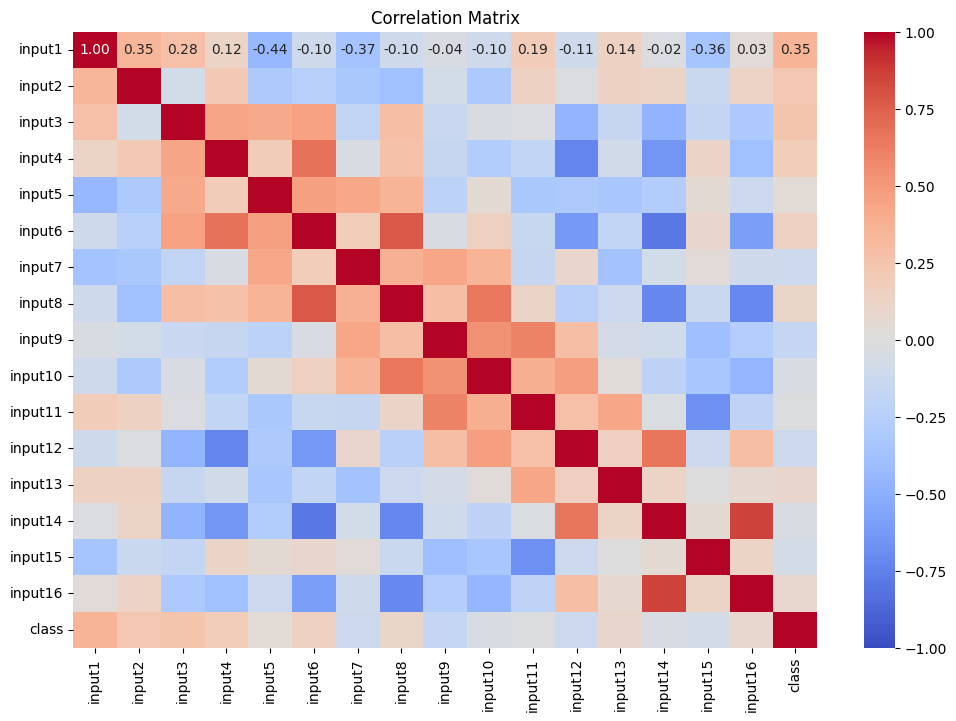

In [10]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [11]:
corr_matrix['class'].sort_values(key=abs, ascending=False)

class      1.000000
input1     0.352199
input3     0.243030
input2     0.232075
input4     0.183646
input9    -0.170221
input6     0.153520
input12   -0.123672
input7    -0.123090
input8     0.108829
input13    0.089234
input16    0.085062
input15   -0.071037
input10   -0.044632
input5     0.039919
input14   -0.036312
input11   -0.011499
Name: class, dtype: float64

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant column for the intercept term
X = add_constant(df.iloc[:, :-1])

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif)

    Feature         VIF
0     const  154.951228
1    input1    2.968385
2    input2    1.905225
3    input3    3.511675
4    input4    5.443810
5    input5    5.950195
6    input6   11.787519
7    input7    5.266628
8    input8   14.721714
9    input9    6.096531
10  input10   10.046788
11  input11    7.668408
12  input12   11.088309
13  input13    2.455634
14  input14   20.361215
15  input15    3.757633
16  input16    8.625732


In [13]:
def identify_outliers(dataframe, column_name, threshold):
    """
    Identify outliers in a given column using the IQR method.
    """
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_limit = Q1 - threshold * IQR
    upper_limit = Q3 + threshold * IQR
    
    # Count outliers
    outliers = dataframe[(dataframe[column_name] < lower_limit) | (dataframe[column_name] > upper_limit)]
    outlier_count = outliers.shape[0]
    
    return lower_limit, upper_limit, outlier_count

In [14]:
# Threshold for identifying outliers
outlier_threshold = 1.5
outlier_summary = {}

In [15]:
# Iterate over each column to find and summarize outliers
for feature in df.columns:
    lower_limit, upper_limit, count = identify_outliers(df, feature, outlier_threshold)
    print(f"Feature: {feature} \tLower Limit: {lower_limit} \tUpper Limit: {upper_limit} \tOutliers: {count}")
    
    outlier_summary[feature] = count

Feature: input1 	Lower Limit: -82.5 	Upper Limit: 153.5 	Outliers: 0
Feature: input2 	Lower Limit: 40.0 	Upper Limit: 136.0 	Outliers: 196
Feature: input3 	Lower Limit: -37.0 	Upper Limit: 115.0 	Outliers: 0
Feature: input4 	Lower Limit: 30.0 	Upper Limit: 142.0 	Outliers: 153
Feature: input5 	Lower Limit: -72.0 	Upper Limit: 168.0 	Outliers: 0
Feature: input6 	Lower Limit: -6.5 	Upper Limit: 141.5 	Outliers: 0
Feature: input7 	Lower Limit: -41.0 	Upper Limit: 143.0 	Outliers: 0
Feature: input8 	Lower Limit: -38.5 	Upper Limit: 125.5 	Outliers: 0
Feature: input9 	Lower Limit: -61.0 	Upper Limit: 179.0 	Outliers: 0
Feature: input10 	Lower Limit: -63.5 	Upper Limit: 124.5 	Outliers: 0
Feature: input11 	Lower Limit: -88.0 	Upper Limit: 208.0 	Outliers: 0
Feature: input12 	Lower Limit: -55.0 	Upper Limit: 121.0 	Outliers: 0
Feature: input13 	Lower Limit: 3.0 	Upper Limit: 107.0 	Outliers: 208
Feature: input14 	Lower Limit: -58.0 	Upper Limit: 110.0 	Outliers: 0
Feature: input15 	Lower Limi

In [16]:
# List columns with outliers
columns_with_outliers = [feature for feature, count in outlier_summary.items() if count > 0]

print("Columns with Outliers:")
print(columns_with_outliers)

Columns with Outliers:
['input2', 'input4', 'input13']


In [17]:
# Remove outliers from a new dataframe

for feature in columns_with_outliers:
    lower_limit, upper_limit, _ = identify_outliers(df, feature, outlier_threshold)
    outliers = df[(df[feature] < lower_limit) | (df[feature] > upper_limit)]
    df = df[~df.index.isin(outliers.index)]

# Print the shape of the cleaned dataframe
print("Shape of cleaned dataframe:")
print(df.shape)

Shape of cleaned dataframe:
(10464, 17)


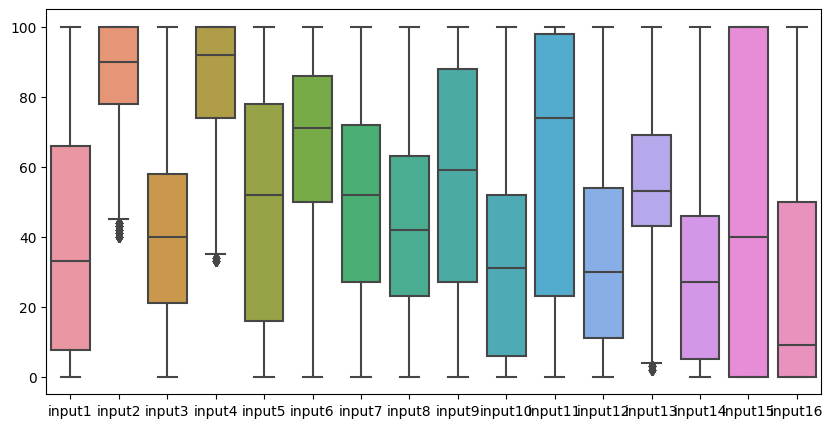

In [18]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df.drop("class", axis = 1))
plt.show()

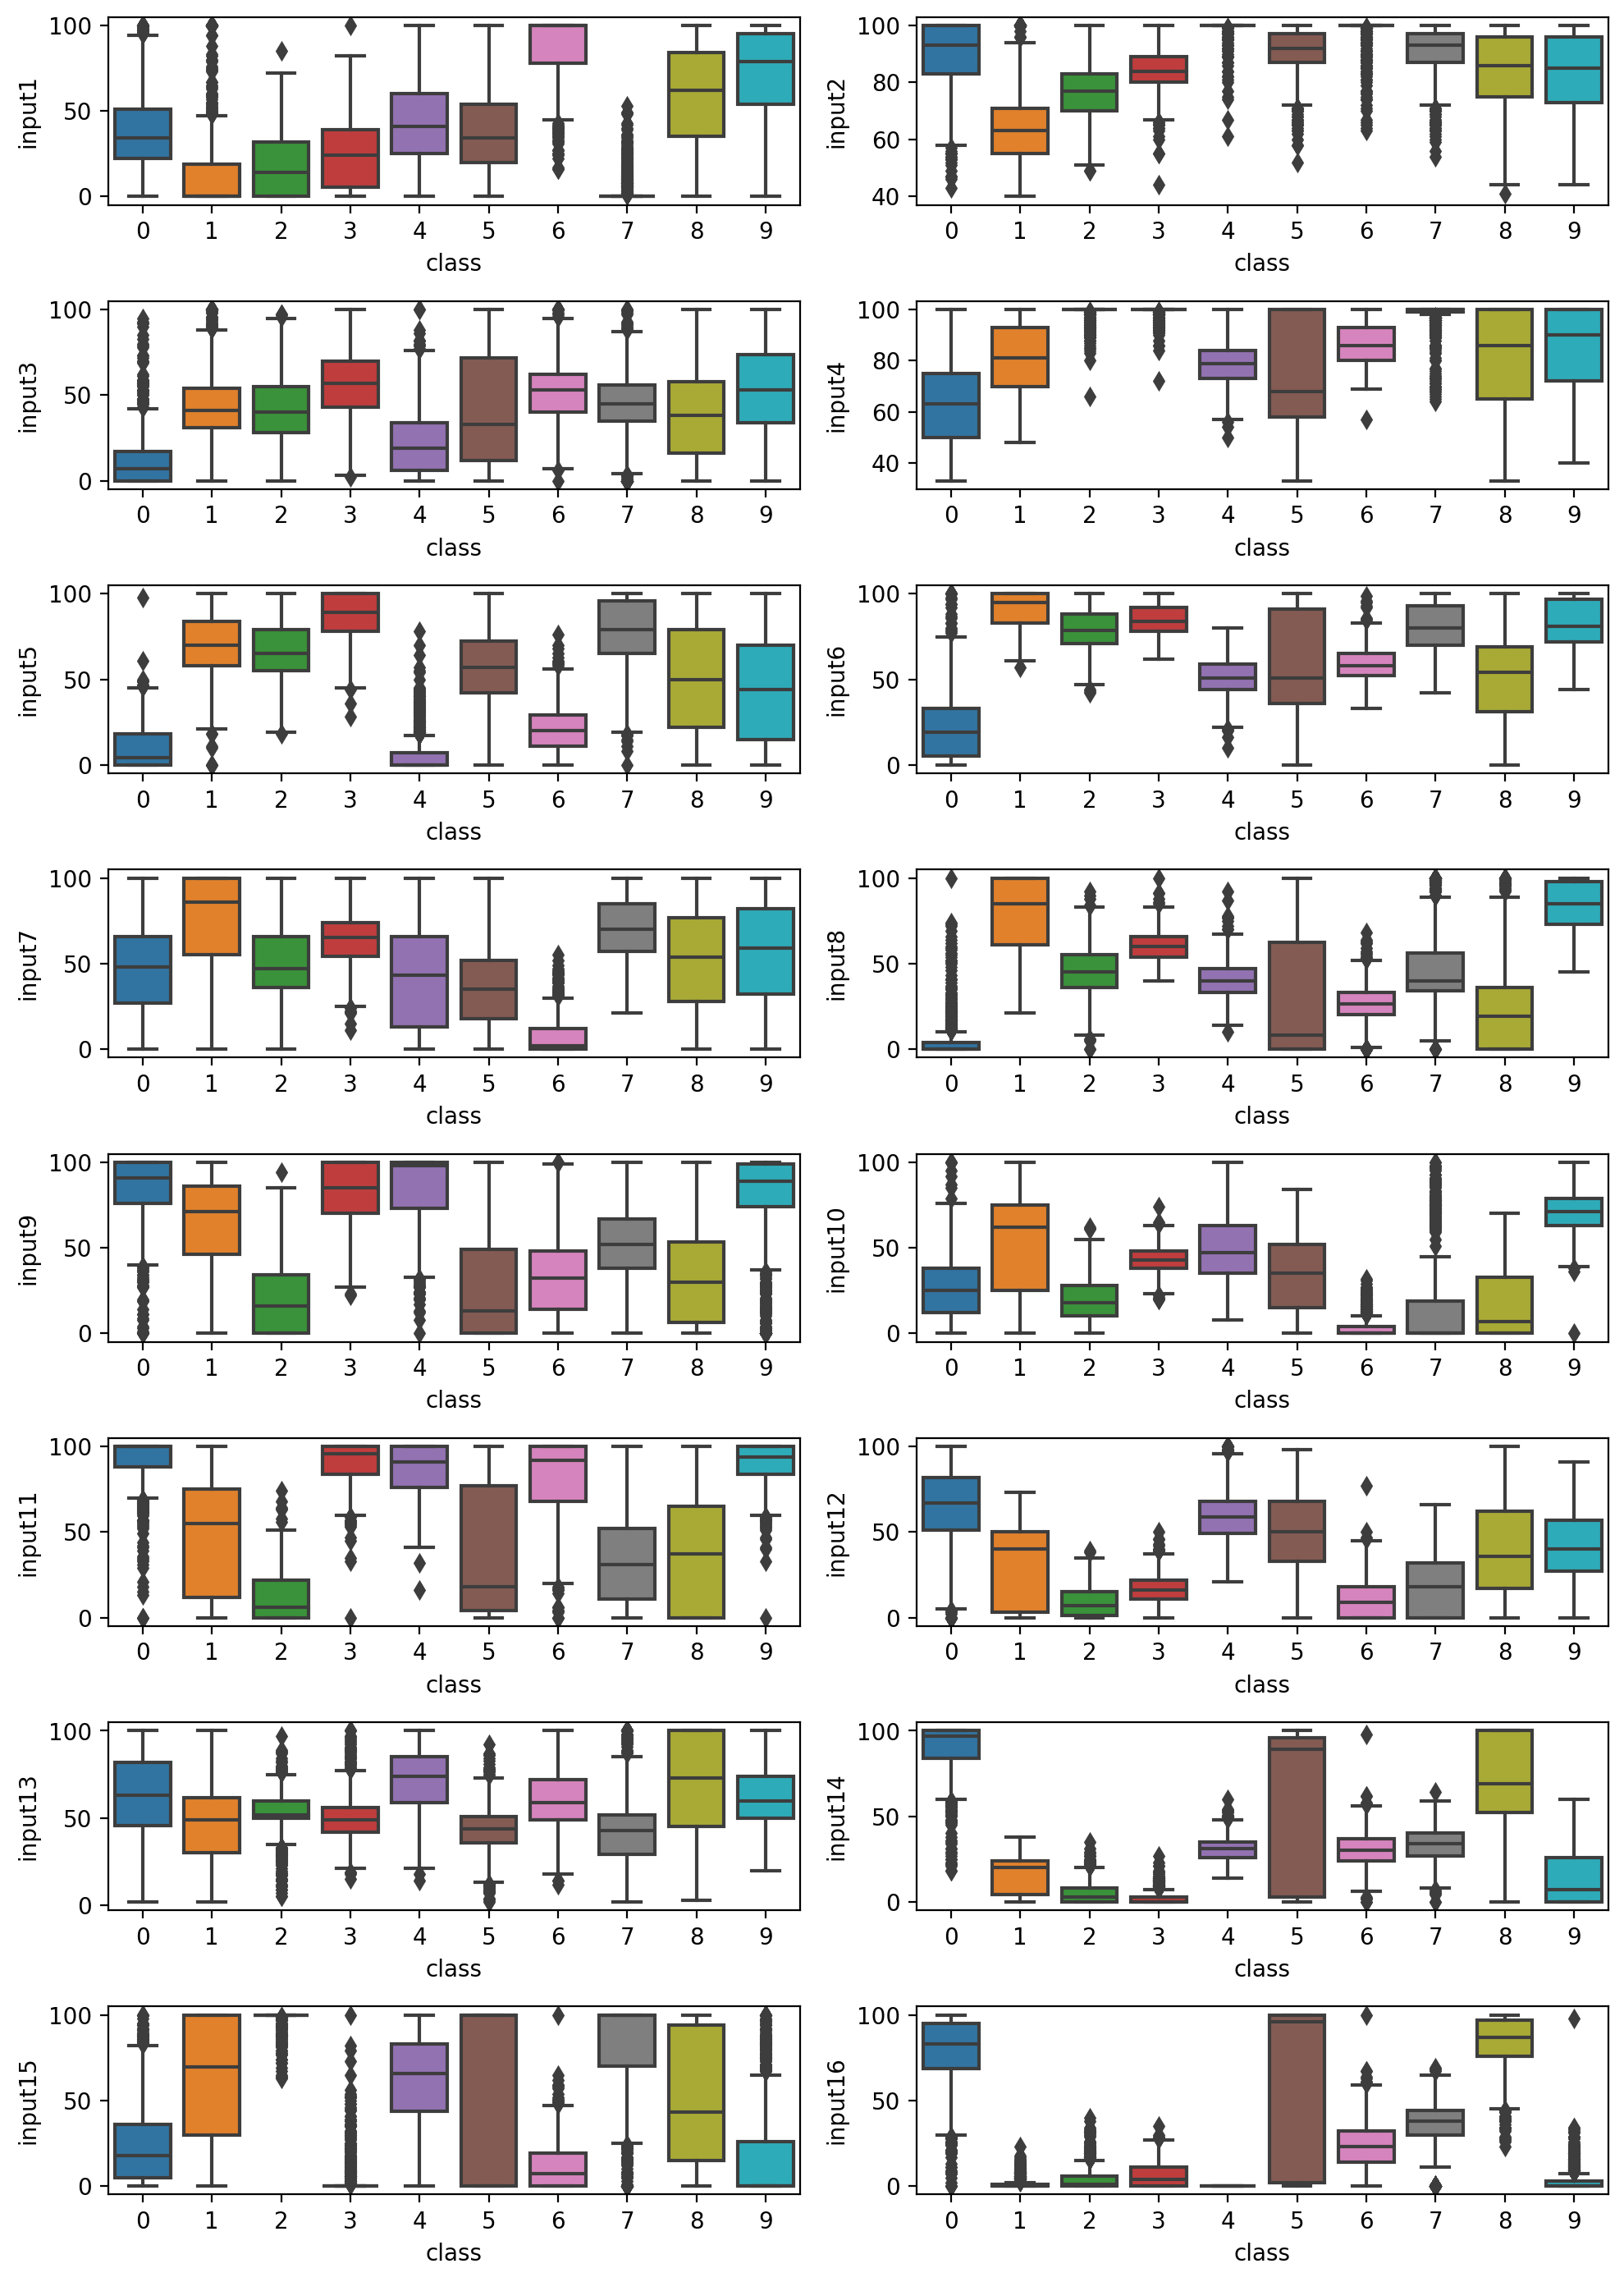

In [19]:
fig = plt.figure(figsize=(10,14), dpi=200)

for i, col in enumerate(df.columns[:-1]):
        plt.subplot(8,2,i+1)
        sns.boxplot(y= df[col], x = df["class"], data=df)

plt.tight_layout()
plt.show()

In [20]:
#Check the balancing of the dataset

df["class"].value_counts()

class
4    1144
2    1134
7    1080
6    1056
3    1054
5    1044
9    1031
8     995
0     992
1     934
Name: count, dtype: int64

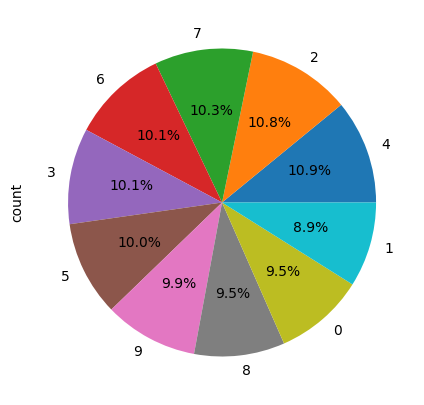

In [21]:
df["class"].value_counts().plot.pie(autopct='%1.1f%%');

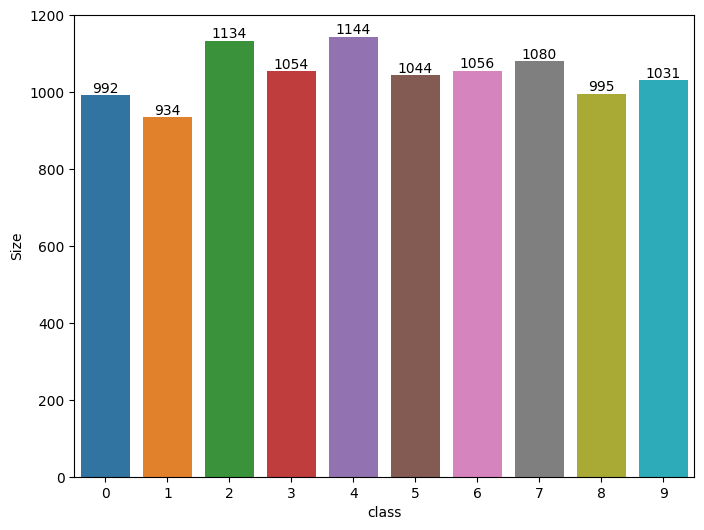

In [22]:
class_digit = df.groupby('class').size()
class_label = pd.DataFrame(class_digit,columns = ['Size'])
plt.figure(figsize = (8,6))
ax= sns.barplot(x = class_label.index, y = 'Size', data = class_label)
plt.bar_label(ax.containers[0]);

<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Train | Test Split</b>
</h1>

In [23]:
X=df.drop(["class"], axis=1)
y=df["class"]

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [25]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Support Vector Machine (SVM) Classifier</b>
</h1>

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
# Create and train the SVC model
# We use a linear kernel and set a random state for reproducibility
svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X_train_scaled, y_train)  # Fit the model on the scaled training data

SVC(kernel='linear', random_state=42)

In [28]:
# Make predictions on the scaled test data
y_pred = svc_model.predict(X_test_scaled)

In [29]:
# Evaluate the model
# Print the confusion matrix to assess the classification accuracy
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the classification report for precision, recall, f1-score, and support
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[203   0   0   0   0   0   0   0   5   0]
 [  0 181   1   0   1   0   1   2   0   0]
 [  0   3 229   0   0   0   0   0   0   0]
 [  0   0   0 188   0   1   0   2   0   0]
 [  0   0   0   0 202   0   0   0   0   0]
 [  1   1   0   2   0 221   0   1   0   1]
 [  0   0   0   0   0   0 227   0   0   0]
 [  0   2   0   1   0   0   0 206   1   0]
 [  6   0   0   0   0   5   0   0 215   1]
 [  0   0   0   0   0   1   0   2   0 180]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       208
           1       0.97      0.97      0.97       186
           2       1.00      0.99      0.99       232
           3       0.98      0.98      0.98       191
           4       1.00      1.00      1.00       202
           5       0.97      0.97      0.97       227
           6       1.00      1.00      1.00       227
           7       0.97      0.98      0.97       210
           8       0.97      0.95      0

## Grid SeachSVC

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, classification_report
from yellowbrick.classifier import ClassPredictionError, ROCAUC

In [31]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('svc', SVC())  # SVC model
])

In [32]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'svc__kernel': ['linear', 'rbf'],  # Kernel types to test
    'svc__C': [0.1, 1, 10],  # Regularization parameters to test
    'svc__gamma': ['scale', 'auto']  # Gamma values to test for 'rbf' kernel
}

In [33]:
# Set up GridSearchCV to find the best hyperparameters
svc_grid_model = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
svc_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [34]:
# Print the best parameters and best score from GridSearchCV
print("Best Parameters:")
print(svc_grid_model.best_params_)

print("\nBest Score:")
print(svc_grid_model.best_score_)

Best Parameters:
{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Best Score:
0.9966550045471567


In [35]:
# Predict using the best model obtained from GridSearchCV
y_pred = svc_grid_model.best_estimator_.predict(X_test)

In [36]:
# Evaluate the best model's performance
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[208   0   0   0   0   0   0   0   0   0]
 [  0 184   0   0   1   0   0   1   0   0]
 [  0   0 232   0   0   0   0   0   0   0]
 [  0   0   1 189   0   1   0   0   0   0]
 [  0   0   0   0 202   0   0   0   0   0]
 [  0   0   0   0   0 226   0   0   0   1]
 [  0   0   0   0   0   0 227   0   0   0]
 [  0   0   0   0   0   0   0 210   0   0]
 [  0   1   0   0   0   1   0   1 224   0]
 [  0   0   0   0   0   1   0   2   0 180]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       0.99      0.99      0.99       186
           2       1.00      1.00      1.00       232
           3       1.00      0.99      0.99       191
           4       1.00      1.00      1.00       202
           5       0.99      1.00      0.99       227
           6       1.00      1.00      1.00       227
           7       0.98      1.00      0.99       210
           8       1.00      0.99      

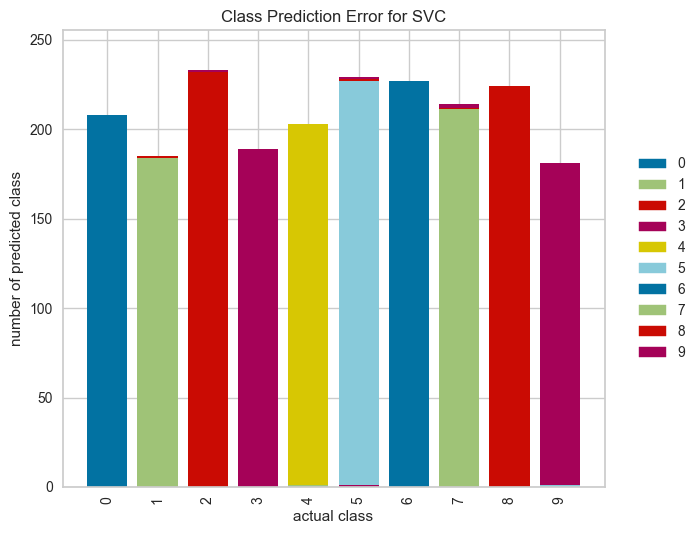

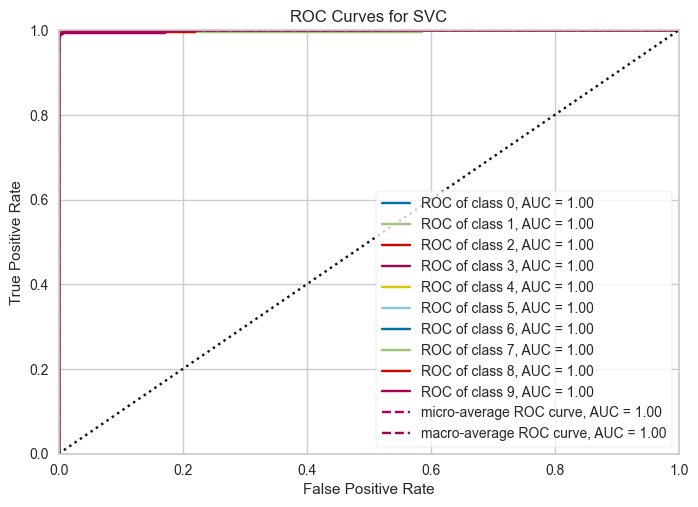

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [37]:
# Visualization: Class Prediction Error and ROCAUC
# Visualize the performance of the best model
visualizer = ClassPredictionError(svc_grid_model.best_estimator_)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# Visualize the ROC-AUC curve for the best model
visualizer = ROCAUC(svc_grid_model.best_estimator_, classes=[str(i) for i in range(10)])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

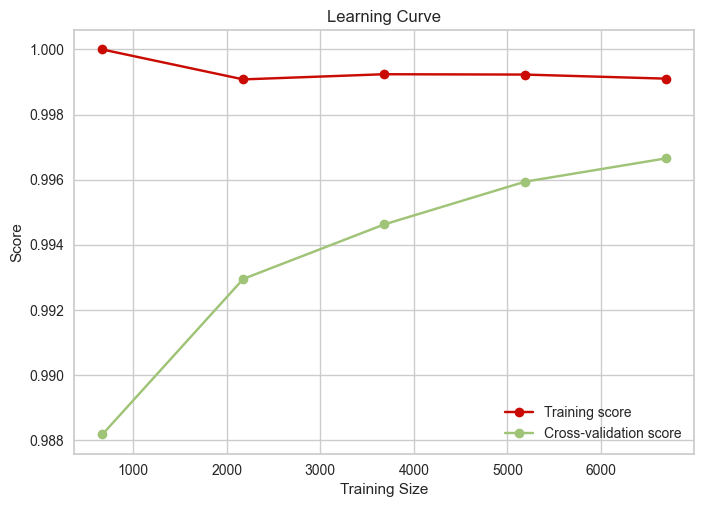

In [38]:
# Learning curve visualization
train_sizes, train_scores, test_scores = learning_curve(
    svc_grid_model.best_estimator_, X_train, y_train, cv=5, n_jobs=-1
)

# Plot the learning curve
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Decision Tree (DT) Classifier</b>
</h1>

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from yellowbrick.classifier import ClassPredictionError
from sklearn.decomposition import PCA

In [40]:
# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)  # Set random_state for reproducibility
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

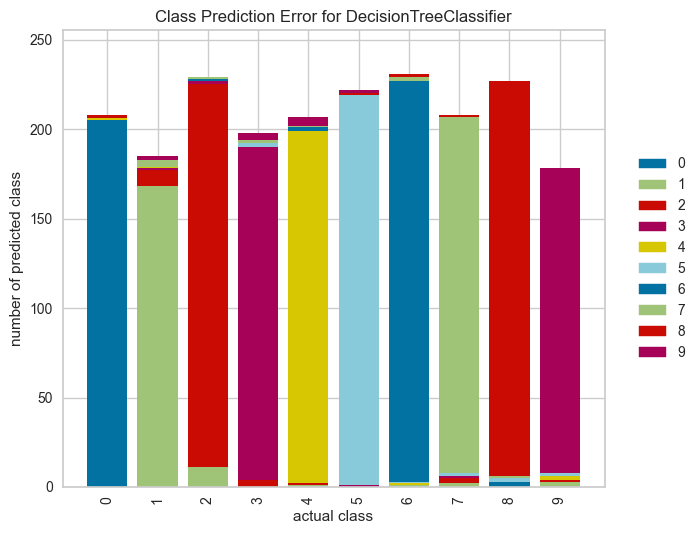

<Axes: title={'center': 'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [41]:
# Visualize class prediction errors

visualizer = ClassPredictionError(dt_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer

visualizer.score(X_test, y_test)  # Evaluate the model on the test data

visualizer.show()  # Draw visualization

In [42]:
# Apply PCA to reduce dimensions to 2 components for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [43]:
# Train Decision Tree model on PCA-transformed data
dt_model_pca = DecisionTreeClassifier(random_state=42)  # Added random_state for consistency
dt_model_pca.fit(X_train_pca, y_train)

DecisionTreeClassifier(random_state=42)

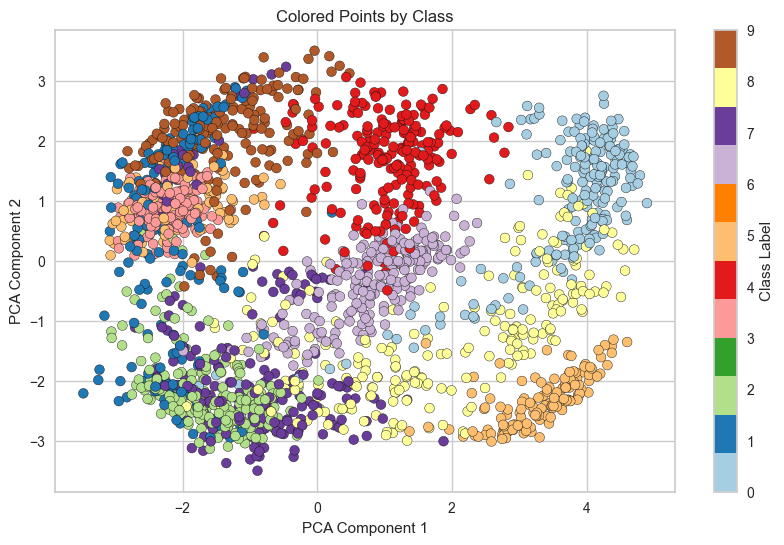

In [44]:
# Function to plot the PCA-transformed test data colored by class labels
def plot_colored_points(X, y):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k', marker='o')
    plt.title('Colored Points by Class')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Class Label')  # Show colorbar for class labels
    plt.show()

# Plot the PCA-transformed test data
plot_colored_points(X_test_pca, y_test)

In [45]:
# Predict using PCA-transformed test data
y_train_pred = dt_model_pca.predict(X_train_pca)
y_test_pred = dt_model_pca.predict(X_test_pca)

In [46]:

# Performance evaluation on original and PCA-transformed data
print("Training Performance (PCA):")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix (Train - PCA):")
print(confusion_matrix(y_train, y_train_pred))

print("\nTest Performance (PCA):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test - PCA):")
print(confusion_matrix(y_test, y_test_pred))

Training Performance (PCA):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       784
           1       1.00      1.00      1.00       748
           2       1.00      1.00      1.00       902
           3       1.00      1.00      1.00       863
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00       817
           6       1.00      1.00      1.00       829
           7       1.00      1.00      1.00       870
           8       1.00      1.00      1.00       768
           9       1.00      1.00      1.00       848

    accuracy                           1.00      8371
   macro avg       1.00      1.00      1.00      8371
weighted avg       1.00      1.00      1.00      8371

Confusion Matrix (Train - PCA):
[[784   0   0   0   0   0   0   0   0   0]
 [  0 748   0   0   0   0   0   0   0   0]
 [  0   0 902   0   0   0   0   0   0   0]
 [  0   0   0 863   0   0   0   0   0   0]
 [  0   0

### Handling with overfitting

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from yellowbrick.classifier import ROCAUC, ClassPredictionError

In [48]:
# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_leaf_nodes': [10, 20, 30]
}

In [49]:
# Initialize and fit GridSearchCV
dt_grid_model = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
dt_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'max_leaf_nodes': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [50]:
# Print the best parameters
print("Best Parameters:")
print(dt_grid_model.best_params_)

Best Parameters:
{'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


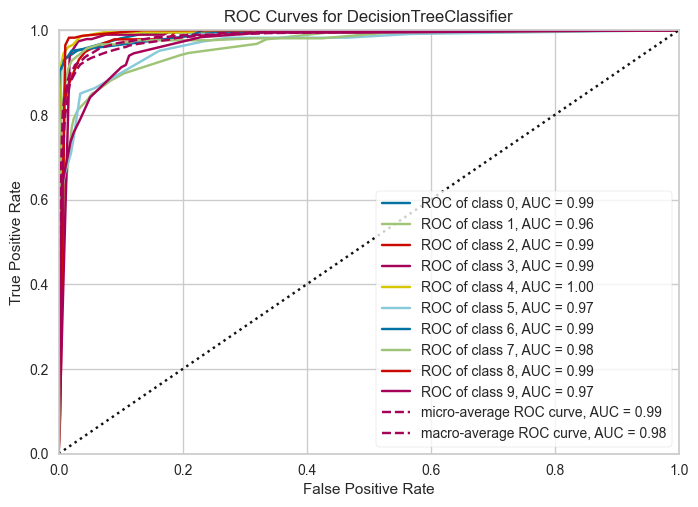

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [51]:
# Visualize ROC-AUC for the best model
visualizer_roc_auc = ROCAUC(dt_grid_model.best_estimator_, classes=[str(i) for i in range(10)])
visualizer_roc_auc.fit(X_train, y_train)  # Fit the training data
visualizer_roc_auc.score(X_test, y_test)  # Score the test data
visualizer_roc_auc.show()  # Show the ROC-AUC curve

In [52]:
# Best model from GridSearchCV
best_dt_model = dt_grid_model.best_estimator_

# Evaluate the best model
y_train_pred = best_dt_model.predict(X_train)
y_test_pred = best_dt_model.predict(X_test)

In [53]:
print("\nTraining Performance:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_train_pred))

print("\nTest Performance:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))


Training Performance:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       784
           1       0.79      0.80      0.80       748
           2       0.89      0.87      0.88       902
           3       0.90      0.93      0.91       863
           4       0.97      0.96      0.96       942
           5       0.79      0.81      0.80       817
           6       0.99      0.89      0.94       829
           7       0.89      0.92      0.90       870
           8       0.87      0.97      0.92       768
           9       0.83      0.77      0.80       848

    accuracy                           0.89      8371
   macro avg       0.89      0.89      0.89      8371
weighted avg       0.89      0.89      0.89      8371

Confusion Matrix (Train):
[[735   1   0   0   2   0   1  13  28   4]
 [  0 602  54  18   3  29   4  18   0  20]
 [  0  82 786   0   0  11   1  19   3   0]
 [  0   2   1 801   0  18   0  29   4   8]
 [  0   1  15   0 90

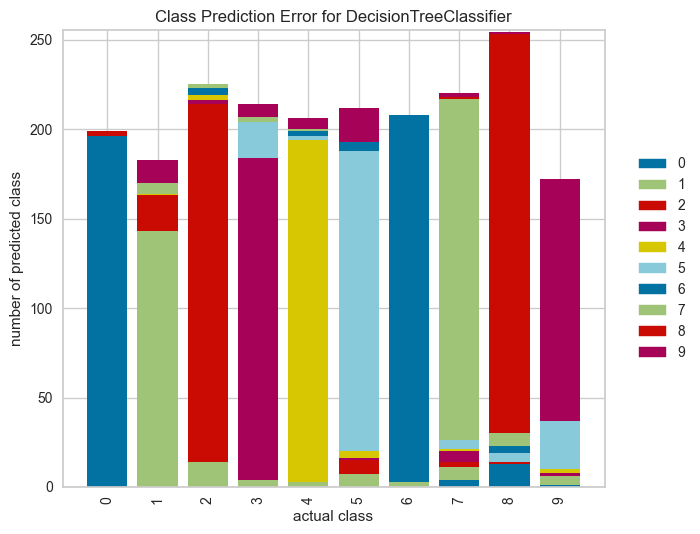

<Axes: title={'center': 'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [54]:
# Visualize class prediction errors for the best model
visualizer_class_pred = ClassPredictionError(best_dt_model)
visualizer_class_pred.fit(X_train, y_train)  # Fit the training data
visualizer_class_pred.score(X_test, y_test)  # Score the test data
visualizer_class_pred.show()  # Show the class prediction error visualization

<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Random Forest Classifier</b>
</h1>

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from yellowbrick.classifier import ClassPredictionError, ROCAUC

In [56]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)  # Set random_state for reproducibility

In [57]:
# Train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [58]:
# Predict on the test set and training set
y_pred_test = rf_model.predict(X_test_scaled)

y_pred_train = rf_model.predict(X_train_scaled)

In [59]:
# Evaluate the model on the test set
print("Test Performance:")
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))

# Evaluate the model on the training set
print("\nTraining Performance:")
print(classification_report(y_train, y_pred_train))
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train))

Test Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       1.00      0.96      0.98       186
           2       0.97      1.00      0.99       232
           3       1.00      0.99      0.99       191
           4       0.99      1.00      0.99       202
           5       1.00      1.00      1.00       227
           6       1.00      1.00      1.00       227
           7       0.98      1.00      0.99       210
           8       1.00      1.00      1.00       227
           9       0.99      0.98      0.99       183

    accuracy                           0.99      2093
   macro avg       0.99      0.99      0.99      2093
weighted avg       0.99      0.99      0.99      2093

Confusion Matrix (Test):
[[208   0   0   0   0   0   0   0   0   0]
 [  0 178   6   0   1   0   0   1   0   0]
 [  0   0 232   0   0   0   0   0   0   0]
 [  0   0   0 189   0   0   0   2   0   0]
 [  0   0   0   0 201   0 

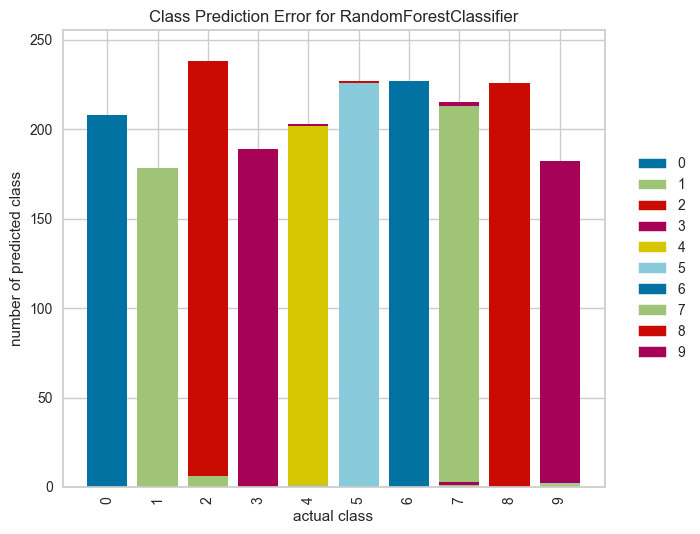

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [60]:
# Visualize class prediction errors
visualizer_class_pred = ClassPredictionError(rf_model)
visualizer_class_pred.fit(X_train_scaled, y_train)  # Fit the training data
visualizer_class_pred.score(X_test_scaled, y_test)  # Score the test data
visualizer_class_pred.show()  # Show the class prediction error visualization

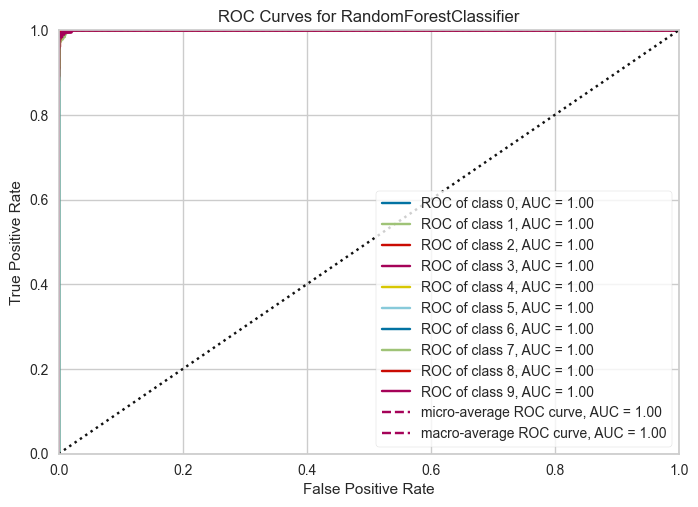

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [61]:
# Visualize ROC-AUC for the Random Forest model
visualizer_roc_auc = ROCAUC(rf_model, classes=[str(i) for i in range(10)])
visualizer_roc_auc.fit(X_train_scaled, y_train)  # Fit the training data
visualizer_roc_auc.score(X_test_scaled, y_test)  # Score the test data
visualizer_roc_auc.show()  # Show the ROC-AUC curve

In [62]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the features
    ('clf', RandomForestClassifier(random_state=42))  # Random Forest model
])

In [63]:
# Define parameter grid for GridSearchCV
param_grid = {
    'clf__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'clf__max_depth': [None, 10, 20],     # Maximum depth of the trees
    'clf__min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

In [64]:
# Set up GridSearchCV
rf_grid_model = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [65]:
# Train the GridSearchCV
rf_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [66]:
# Best parameters and best score
print("Best Parameters:")
print(rf_grid_model.best_params_)

print("\nBest Score:")
print(rf_grid_model.best_score_)

Best Parameters:
{'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

Best Score:
0.9910405677704667


In [67]:
# Predict using the best model
y_pred_test = rf_grid_model.best_estimator_.predict(X_test)
y_pred_train = rf_grid_model.best_estimator_.predict(X_train)

In [68]:
# Evaluate the model on the test set
print("\nTest Performance:")
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))

# Evaluate the model on the training set
print("\nTraining Performance:")
print(classification_report(y_train, y_pred_train))
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train))


Test Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       1.00      0.96      0.98       186
           2       0.97      1.00      0.99       232
           3       1.00      0.99      0.99       191
           4       0.99      1.00      0.99       202
           5       1.00      1.00      1.00       227
           6       1.00      1.00      1.00       227
           7       0.98      1.00      0.99       210
           8       1.00      1.00      1.00       227
           9       0.99      0.98      0.99       183

    accuracy                           0.99      2093
   macro avg       0.99      0.99      0.99      2093
weighted avg       0.99      0.99      0.99      2093

Confusion Matrix (Test):
[[208   0   0   0   0   0   0   0   0   0]
 [  0 178   6   0   1   0   0   1   0   0]
 [  0   0 232   0   0   0   0   0   0   0]
 [  0   0   0 189   0   0   0   2   0   0]
 [  0   0   0   0 201   0

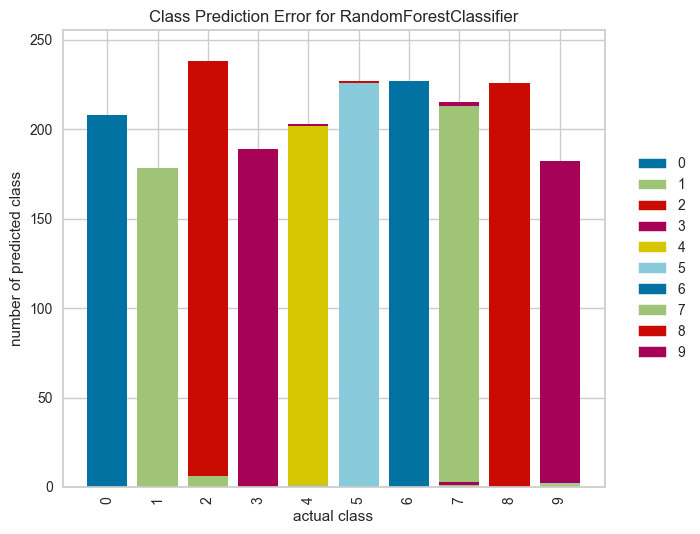

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [69]:
# Visualize class prediction errors
visualizer_class_pred = ClassPredictionError(rf_grid_model.best_estimator_)
visualizer_class_pred.fit(X_train, y_train)
visualizer_class_pred.score(X_test, y_test)
visualizer_class_pred.show()

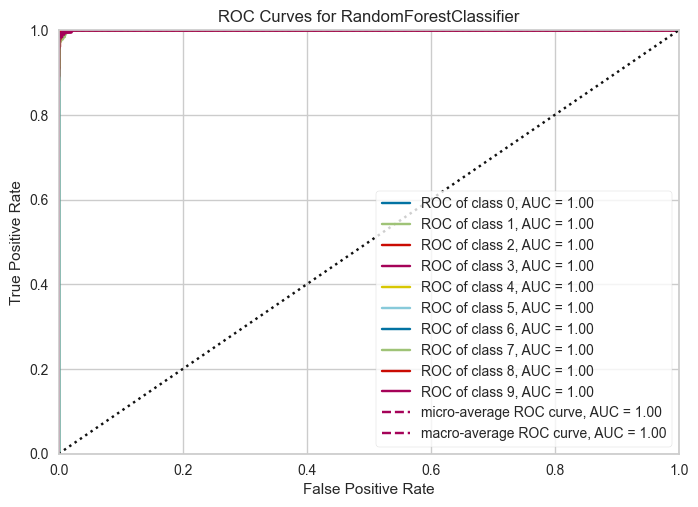

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [70]:
# Visualize ROC-AUC
visualizer_roc_auc = ROCAUC(rf_grid_model.best_estimator_, classes=[str(i) for i in range(10)])
visualizer_roc_auc.fit(X_train, y_train)
visualizer_roc_auc.score(X_test, y_test)
visualizer_roc_auc.show()

<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Compare The Models</b>
</h1>

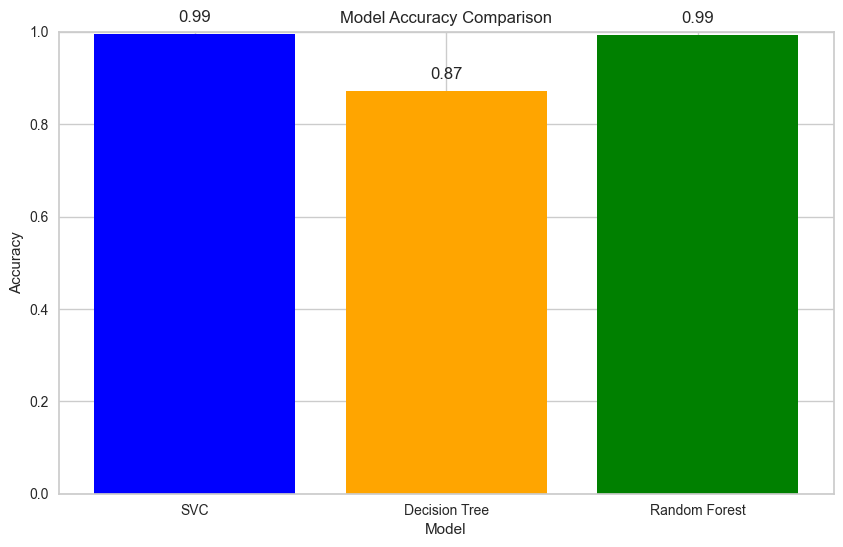

In [71]:
from sklearn.metrics import accuracy_score

# Define models and their names
models = {
    'SVC': svc_grid_model,
    'Decision Tree': best_dt_model,
    'Random Forest': rf_grid_model.best_estimator_  # Using best model from GridSearchCV
}

# Calculate accuracy scores
accuracy_scores = {}
for name, model in models.items():
    y_pred = model.predict(X_test)  # Predict on the test set
    accuracy_scores[name] = accuracy_score(y_test, y_pred)

# Plotting the results
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

plt.show()

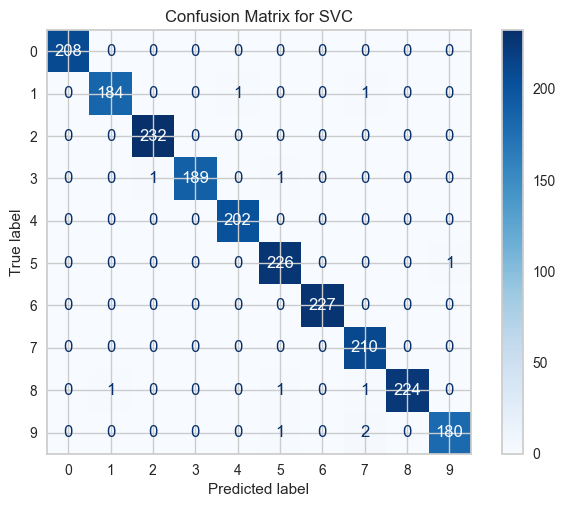

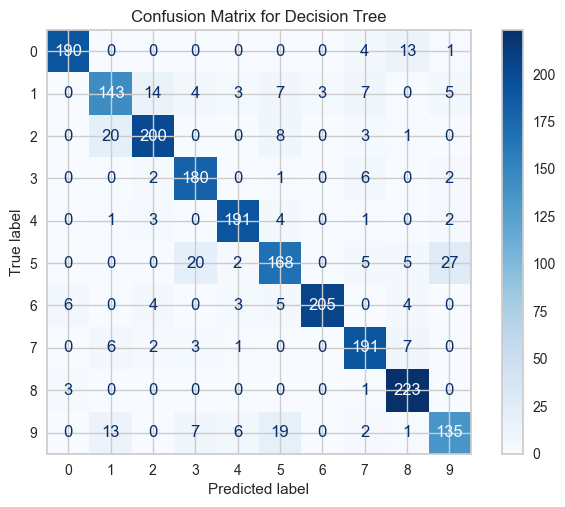

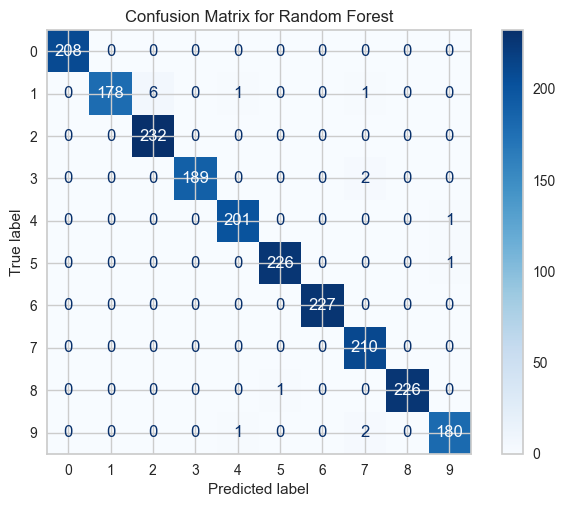

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay

# Iterate over each model in the 'models' dictionary
for name, model in models.items():
    # Predict the labels on the test set using the current model
    y_pred = model.predict(X_test)
    
    # Compute the confusion matrix by comparing the true labels (y_test) with the predicted labels (y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a ConfusionMatrixDisplay object to visualize the confusion matrix
    # 'display_labels' specifies the class labels to use in the visualization
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
    
    # Plot the confusion matrix with a blue color map for better visual distinction
    disp.plot(cmap=plt.cm.Blues)
    
    # Set the title of the plot to indicate which model's confusion matrix is being displayed
    plt.title(f'Confusion Matrix for {name}')
    
    # Show the plot on the screen
    plt.show()

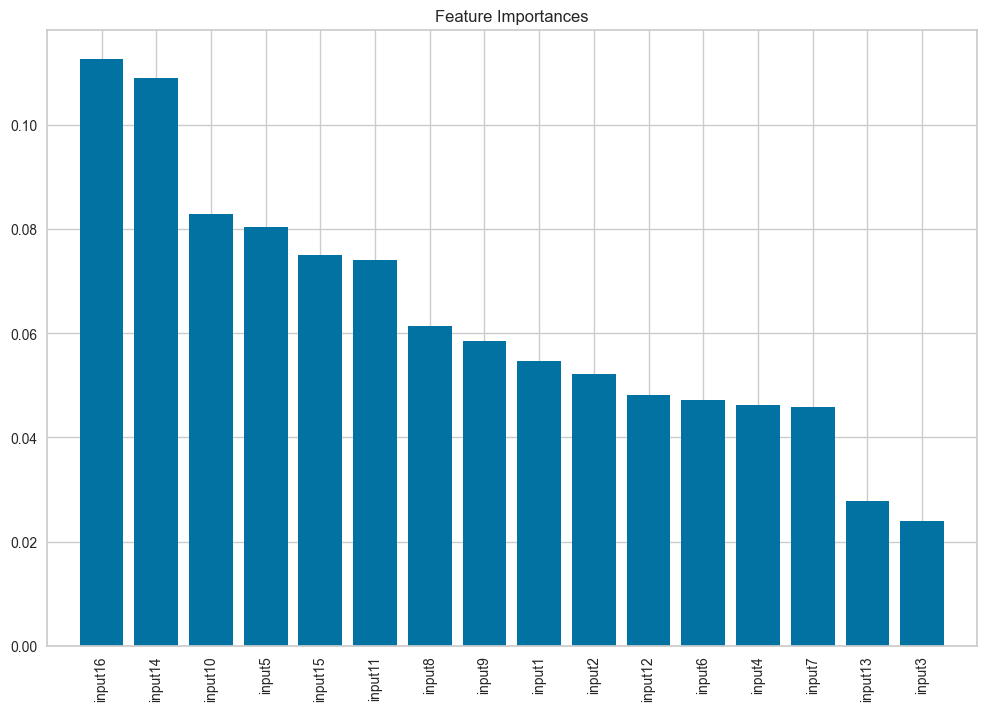

In [73]:
# Feature importance for RandomForest

# Extract feature importances from the best estimator in the grid search pipeline
importances = rf_grid_model.best_estimator_.named_steps['clf'].feature_importances_

# Get the indices of the feature importances sorted in descending order
indices = np.argsort(importances)[::-1]

# Create a new figure for the plot with specified dimensions
plt.figure(figsize=(12, 8))

# Set the title for the plot
plt.title('Feature Importances')

# Create a bar plot of the feature importances, ordered from most to least important
plt.bar(range(X_train.shape[1]), importances[indices], align='center')

# Set the x-ticks labels to the corresponding feature names, rotated for better readability
plt.xticks(range(X_train.shape[1]), np.array(X_train.columns)[indices], rotation=90)

# Set the limits for the x-axis to ensure all features are displayed
plt.xlim([-1, X_train.shape[1]])

# Display the plot on the screen
plt.show()

<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Chosee The Best Model</b>
</h1>

## Support Vector Classifier (SVC):

Test Accuracy: 99%
The SVC model demonstrated excellent performance, achieving nearly perfect classification across all classes. The model had very few misclassifications, indicating its robustness. However, it struggled slightly with classes that had imbalanced distributions, as seen in the precision and recall for certain classes (e.g., class 1). Overall, SVC proved to be a strong classifier for this dataset.


## Decision Tree Classifier:

Test Accuracy: 87%
The Decision Tree model, while still performing well, showed more variance in its performance. The model had some difficulty with specific classes, particularly classes 1, 5, and 9, where the recall and precision were lower. This suggests that the Decision Tree might be overfitting to the training data, as evidenced by its lower test accuracy compared to its training accuracy. The confusion matrix shows a spread of misclassifications across several classes, indicating that the model's decision boundaries are not as clear-cut as those of SVC or Random Forest.

## Random Forest Classifier:

Test Accuracy: 99%
The Random Forest model outperformed the Decision Tree and matched the performance of SVC. It achieved near-perfect precision and recall across almost all classes, with minimal misclassifications. The model's performance on the training set was also impeccable, indicating that it generalized well to the test data. Random Forest's ensemble nature helped mitigate the overfitting issue seen in the Decision Tree, making it a highly reliable model for this classification task.

### Overall Assessment:

Among the three models, Random Forest and SVC emerged as the top performers with almost identical metrics, achieving 99% accuracy on the test set. However, Random Forest may have a slight edge due to its ability to handle class imbalances more effectively and its robustness across different classes. The Decision Tree, while still effective, displayed some overfitting tendencies and had lower overall accuracy, making it less reliable compared to the other two models.
In conclusion, both Random Forest and SVC are excellent choices for this classification task, with Random Forest being slightly preferable due to its consistency and overall performance.

<h1 style="background-color: #4682B4; font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
  <b>Final Model</b>
</h1>

In [74]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [75]:
# Initialize and train the RandomForest model
final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
# Evaluate the final model
final_train_score = final_rf_model.score(X_train, y_train)
final_test_score = final_rf_model.score(X_test, y_test)
print(f"Final Model Training Accuracy: {final_train_score:.4f}")
print(f"Final Model Test Accuracy: {final_test_score:.4f}")

Final Model Training Accuracy: 1.0000
Final Model Test Accuracy: 0.9924


In [77]:
import joblib

# Save the model
joblib.dump(final_rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']